# Capítulo 16

### Análise de séries temporais.
#### Suavização exponencial.

### Problema de negócio...
#### Usando dados históricos das vendas ao longo de 2023 seria possível prever o total de vendas em janeiro/2024

In [6]:
# buscando dados históricos para análise (imprescindível)
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
df_dsa=pd.read_csv('dataset.csv')
df_dsa.shape

(365, 2)

In [7]:
df_dsa.columns

Index(['Data', 'Total_Vendas'], dtype='object')

In [8]:
df_dsa.head()

,Data,Total_Vendas
0,2023-01-01,53.483571
1,2023-01-02,57.176993
2,2023-01-03,63.087722
3,2023-01-04,62.103987
4,2023-01-05,44.690396


In [9]:
df_dsa.tail()

,Data,Total_Vendas
360,2023-12-27,74.935570
361,2023-12-28,71.374857
362,2023-12-29,57.806920
363,2023-12-30,62.340244
364,2023-12-31,71.650720


#### Pré-processamento dos dados

In [10]:
# valor mínimo da coluna data
df_dsa['Data'].min()

'2023-01-01'

In [11]:
# valor máximo da coluna data
df_dsa['Data'].max()

'2023-12-31'

In [12]:
# informações dos dados
df_dsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Data          365 non-null    object 
 1   Total_Vendas  365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [14]:
# converte a coluna de data em tipo datetime
df_dsa['Data']=pd.to_datetime(df_dsa['Data'])
df_dsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Data          365 non-null    datetime64[ns]
 1   Total_Vendas  365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [15]:
df_dsa.head()

,Data,Total_Vendas
0,2023-01-01,53.483571
1,2023-01-02,57.176993
2,2023-01-03,63.087722
3,2023-01-04,62.103987
4,2023-01-05,44.690396


In [16]:
# converter o dataframe em uma série temporal com a data como indice
serie_temporal=df_dsa.set_index('Data')['Total_Vendas']
type(serie_temporal)

pandas.core.series.Series

In [17]:
serie_temporal

Data
2023-01-01    53.483571
2023-01-02    57.176993
2023-01-03    63.087722
2023-01-04    62.103987
2023-01-05    44.690396
                ...    
2023-12-27    74.935570
2023-12-28    71.374857
2023-12-29    57.806920
2023-12-30    62.340244
2023-12-31    71.650720
Name: Total_Vendas, Length: 365, dtype: float64

In [18]:
# fornece a frequência da série temporal (diária, neste caso)
serie_temporal=serie_temporal.asfreq('D')
serie_temporal

Data
2023-01-01    53.483571
2023-01-02    57.176993
2023-01-03    63.087722
2023-01-04    62.103987
2023-01-05    44.690396
                ...    
2023-12-27    74.935570
2023-12-28    71.374857
2023-12-29    57.806920
2023-12-30    62.340244
2023-12-31    71.650720
Freq: D, Name: Total_Vendas, Length: 365, dtype: float64

#### Análise exploratória

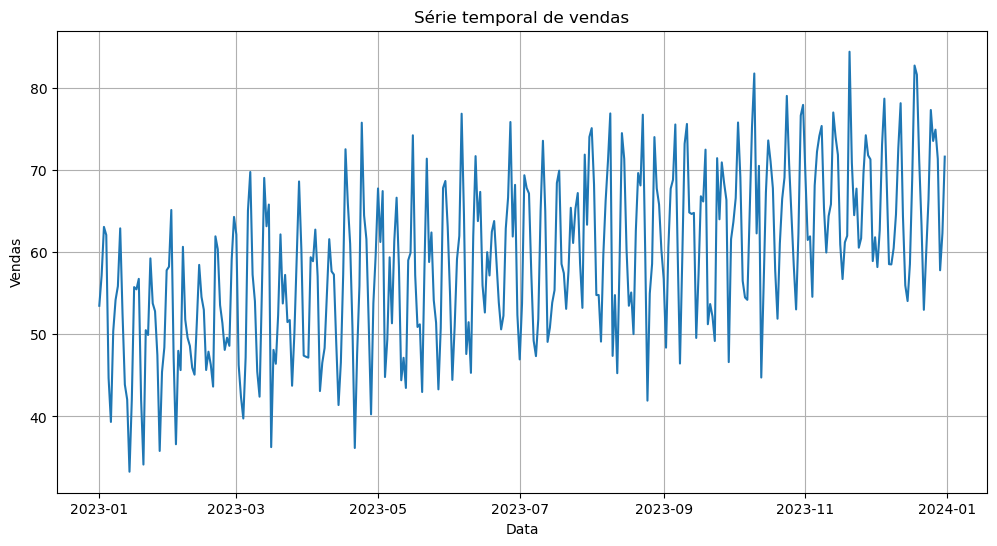

In [19]:
# cria o gráfico da série temporal (sem formatação)
plt.figure(figsize=(12,6)) # cria a area de plotagem
plt.plot(serie_temporal) # plota a série temporal
plt.xlabel('Data') # Label
plt.ylabel('Vendas') # Label
plt.title('Série temporal de vendas')
plt.grid(True) # cria uma grade
plt.show()

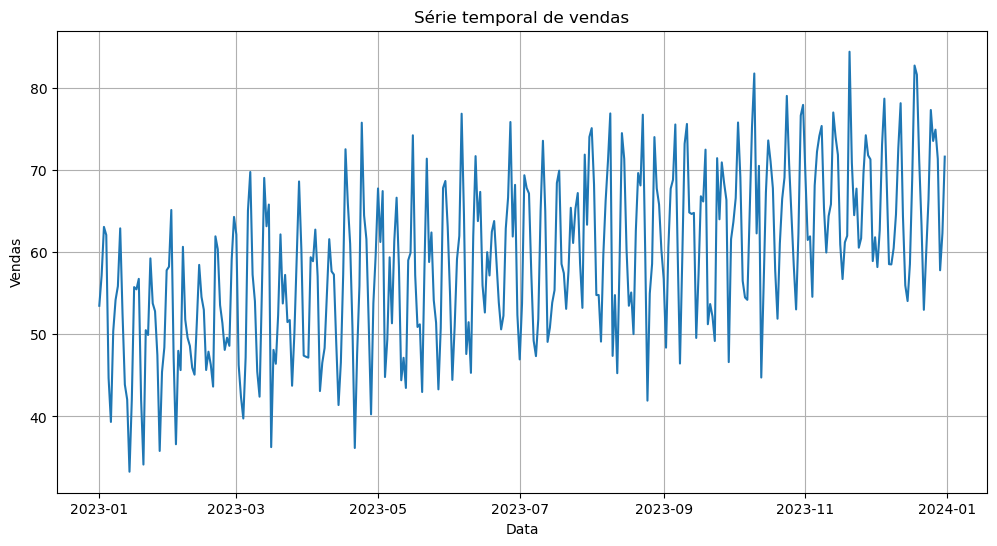

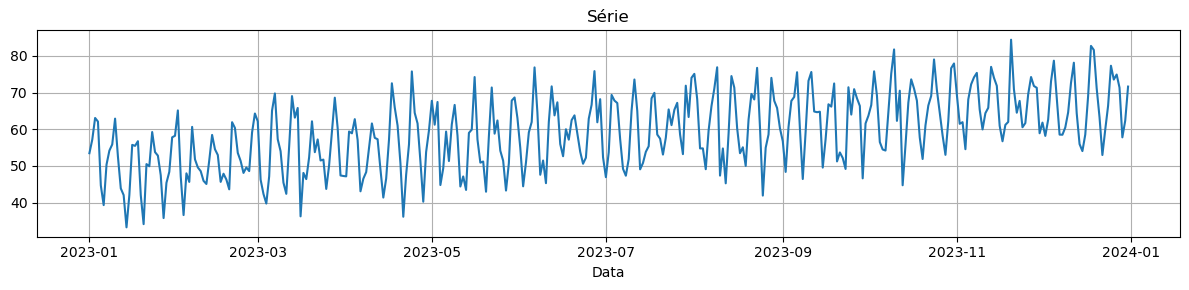

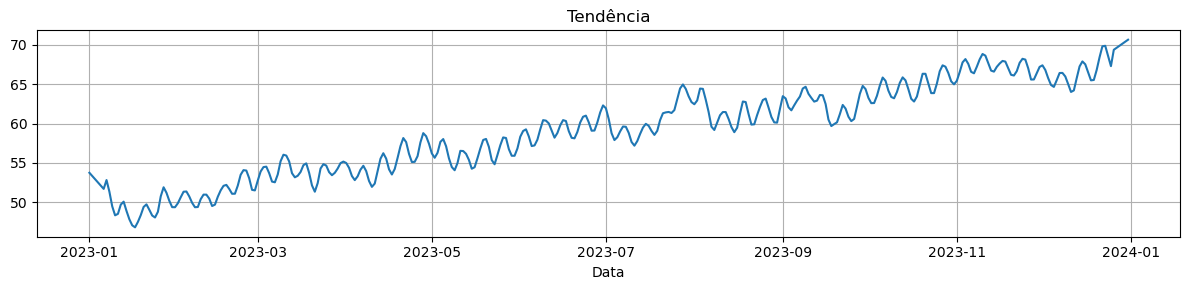

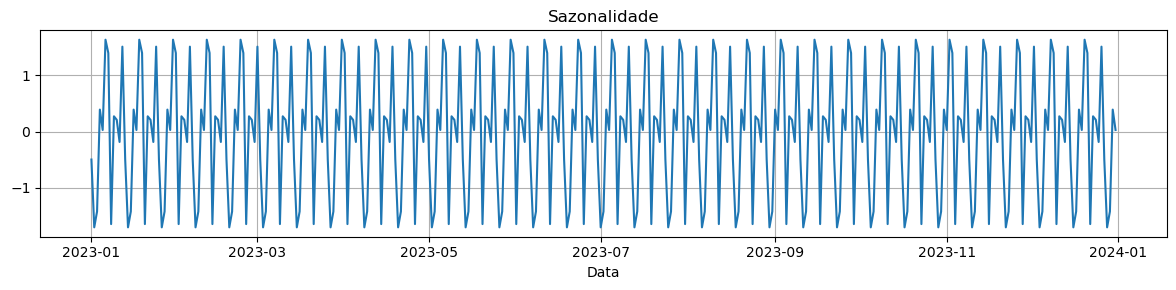

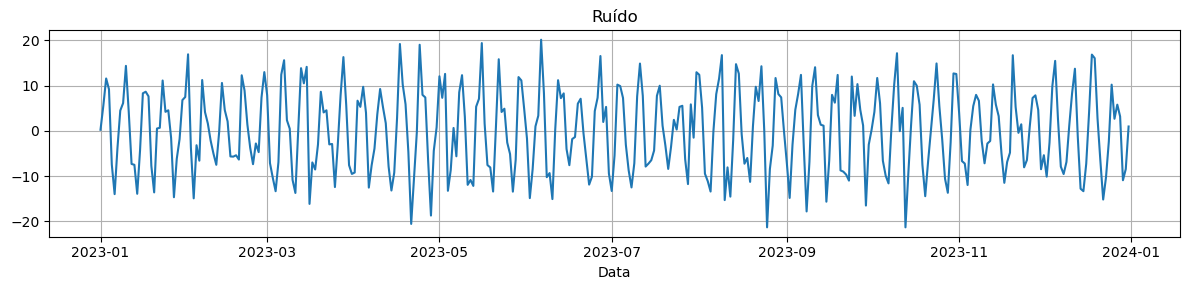

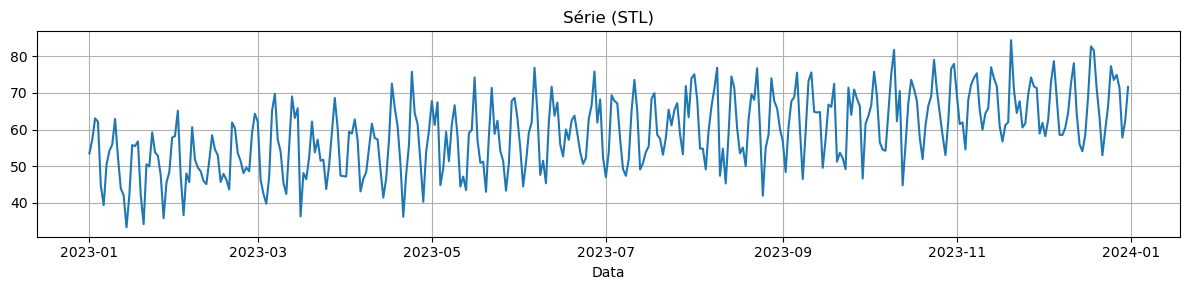

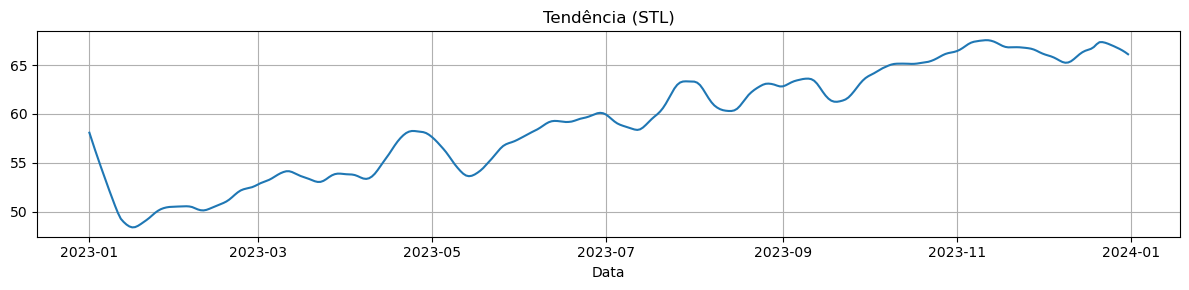

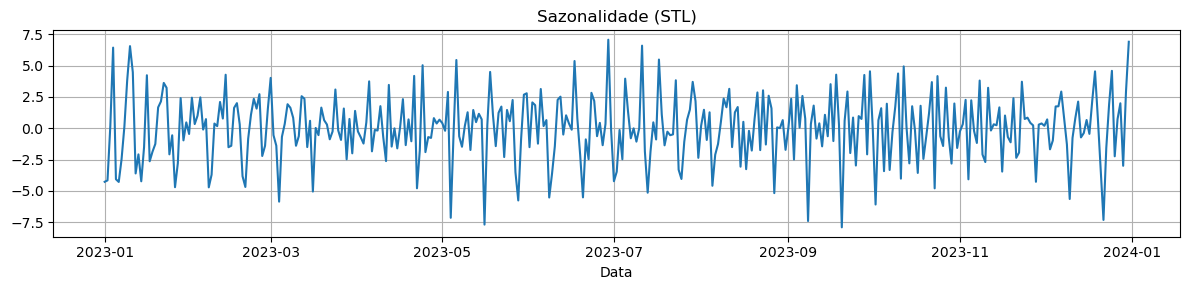

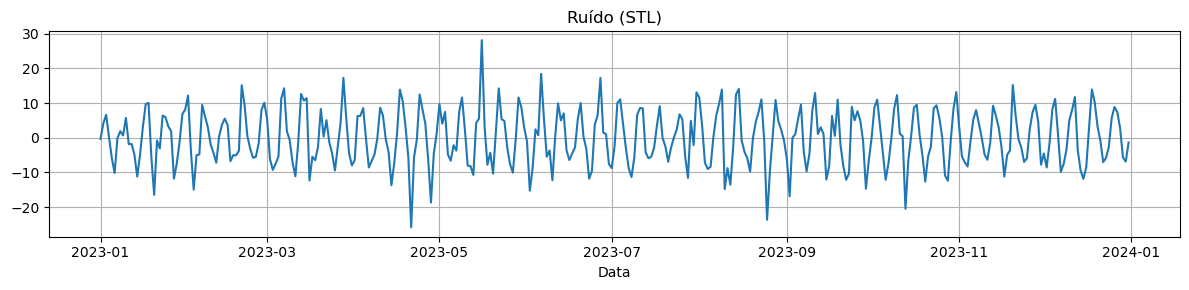

In [20]:
# é possível decompor a série temporal dividindo em 4 partes
# série, tendência, sazonalidade e ruído

from statsmodels.tsa.seasonal import seasonal_decompose, STL

# --- 1) Preparação da série ---
# (supondo que 'serie_temporal' já é um pandas Series com índice de datas)
serie_temporal = serie_temporal.sort_index()
serie_temporal.index = pd.to_datetime(serie_temporal.index)

# Se a série não tiver frequência explícita, defina:
# Ex.: mensal -> 'MS' (início do mês), diária -> 'D'
if serie_temporal.index.freq is None:
    # tente inferir; se não conseguir, force a desejada (ex.: 'MS' para mensal)
    try:
        serie_temporal = serie_temporal.asfreq(pd.infer_freq(serie_temporal.index))
    except Exception:
        serie_temporal = serie_temporal.asfreq('MS')  # ajuste conforme seu caso

# Opcional: tratar valores faltantes após o asfreq
serie_temporal = serie_temporal.interpolate(method='time')

# --- 2) Defina o período sazonal ---
# Ajuste conforme sua frequência:
# mensal -> 12 | semanal -> 7 | diária c/ padrão semanal -> 7 | anual (mensal) -> 12 | anual (diária) -> 365
period = 12  # <-- ALTERE AQUI se necessário

# --- 3A) Decomposição clássica (seasonal_decompose) ---
decomp = seasonal_decompose(serie_temporal, model='additive', period=period, extrapolate_trend='freq')

# Plot original (sem formatação, como você já faz)
plt.figure(figsize=(12,6))
plt.plot(serie_temporal)
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Série temporal de vendas')
plt.grid(True)
plt.show()

# Plots dos componentes (um gráfico por componente)
componentes = {
    'Série': serie_temporal,
    'Tendência': decomp.trend,
    'Sazonalidade': decomp.seasonal,
    'Ruído': decomp.resid
}

for titulo, serie in componentes.items():
    plt.figure(figsize=(12,3))
    plt.plot(serie)
    plt.xlabel('Data')
    plt.title(titulo)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 3B) Decomposição robusta (STL) — alternativa recomendada ---
stl = STL(serie_temporal, period=period, robust=True).fit()

componentes_stl = {
    'Série (STL)': serie_temporal,
    'Tendência (STL)': stl.trend,
    'Sazonalidade (STL)': stl.seasonal,
    'Ruído (STL)': stl.resid
}

for titulo, serie in componentes_stl.items():
    plt.figure(figsize=(12,3))
    plt.plot(serie)
    plt.xlabel('Data')
    plt.title(titulo)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



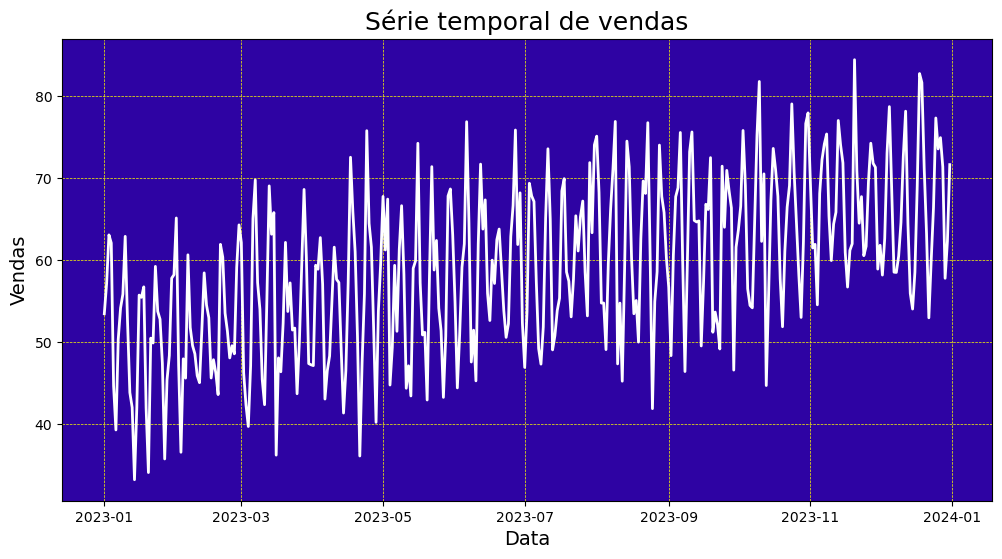

In [23]:
# cria um novo gráfico de série temporal (com formatação)
# criar o gráfico com contraste
plt.figure(figsize=(12,6))
plt.plot(serie_temporal, color='white', linewidth=2)

# configura cores e estilos
plt.gca().set_facecolor('#2e03a3')
plt.grid(color='yellow',linestyle='--' ,linewidth=0.5)

# configurar rótulos e eixos, títulos e legenda
plt.xlabel('Data', color='black', fontsize=14)
plt.ylabel('Vendas', color='black', fontsize=14)
plt.title('Série temporal de vendas', color='black', fontsize=18)

# configura as cores dos eixos e dos ticks (marcadores)
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')

plt.show()

#### Suavização Exponencial

No Statsmodels, a classe SimpleExpSmoothing é uma implementação da técnica de suavização exponencial simples, que é uma versão mais básica da
suavização exponencial que não lida explicitamente com tendências e sazonalidades.

O modelo SimpleExpSmoothing do Statsmodels, também conhecido como suavização exponencial simples ou média móvel exponencialmente ponderada, é
uma técnica de suavização de séries temporais que atribui pesos decrescentes exponencialmente aos pontos de dados passados. Ele é usado
principalmente para suavizar séries temporais e fazer previsões de curto prazo. As principais suposições do modelo SimpleExpSmoothing são as seguintes:

· A série temporal é composta por um componente de nível (média) e um componente de erro aleatório (ruído). Não há componentes de tendência ou
sazonalidade na série.

· O componente de nivel é uma média ponderada dos valores passados, com pesos que diminuem exponencialmente à medida que os dados ficam mais
distantes no passado.

. O componente de erro aleatório é normalmente distribuído com média zero e variância constante. Além disso, os erros são independentes e
identicamente distribuídos.

· O parâmetro de suavização (alfa) é uma constante entre 0 e 1, que determina a taxa de decaimento dos pesos. Valores próximos a 1 dão maior peso aos
dados mais recentes, enquanto valores próximos a 0 dão mais peso aos dados mais antigos.

O modelo SimpleExpSmoothing é uma técnica de suavização bastante simples que tem suas limitações. Ele é mais adequado para séries temporais que não
apresentam tendências ou sazonalidades claras e para fazer previsões de curto prazo. Para séries temporais com componentes de tendência e/ou
sazonalidade, modelos mais avançados como o ExponentialSmoothing de Holt-Winters ou modelos SARIMA podem ser mais apropriados.

### VALIDAÇÃO DE SUPOSIÇÕES...

1. Estacionariedade
Necessária para ARIMA/SARIMA.

from statsmodels.tsa.stattools import adfuller

resultado = adfuller(serie_temporal)
print('ADF:', resultado[0])
print('p-valor:', resultado[1])

if resultado[1] <= 0.05:
    print("Série estacionária (não precisa diferenciar).")
else:
    print("Série não estacionária (precisa diferenciar).")

2. Normalidade dos resíduos
Podemos usar o teste de Shapiro-Wilk.

from scipy.stats import shapiro

stat, p = shapiro(residuos)
print('p-valor:', p)
print("Resíduos normais." if p > 0.05 else "Resíduos não normais.")

3. Autocorrelação dos resíduos
Deve ser próxima de zero. Use Ljung-Box.

from statsmodels.stats.diagnostic import acorr_ljungbox

lb, p = acorr_ljungbox(residuos, lags=[10])
print("p-valor:", p)
print("Sem autocorrelação." if p[0] > 0.05 else "Autocorrelação detectada.")

4. Heterocedasticidade
Verifica se a variância é constante (teste de Breusch-Pagan).

from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

X = sm.add_constant(range(len(residuos)))
bp_test = het_breuschpagan(residuos, X)

print(f"p-valor: {bp_test[1]}")
print("Homoscedasticidade" if bp_test[1] > 0.05 else "Heterocedasticidade detectada.")

5. Visualização geral das suposições
Podemos usar o plot_diagnostics do statsmodels:

import statsmodels.api as sm

modelo = sm.tsa.ARIMA(serie_temporal, order=(1,1,1)).fit()
modelo.plot_diagnostics(figsize=(12,8))
plt.show()
Ele exibe:

Histograma dos resíduos.

QQ-plot para normalidade.

ACF dos resíduos.

Probabilidade acumulada.



In [27]:
# cria o modelo
modelo = SimpleExpSmoothing(serie_temporal)

In [28]:
# treinamento (ajuste) do modelo
   #Esta linha acima faz uma chamada ao método fit() para ajustar o modelo de suavização exponencial aos dados. O argumento smoothing_level=0.2 define o parametro de suavizaçao (alfa) como 0.2. O parametro de suavizaçao controla a rapidez com que os pesos decrescem ao longo do tempo; um valor maior atribui mais peso aos dados mais recentes, enquanto um valor menor atribui mais peso aos dados mais antigos. O valor de alfa deve estar entre 0 e 1.
modelo_ajustado = modelo.fit(smoothing_level=0.2)

c:\Users\massa\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [ ]:
# extrai os valores previstos pelo modelo

    #Esta linha acima extrai os valores ajustados do modelo de suavização exponencial. Os valores ajustados são as estimativas da série temporal suavizada, que são calculadas aplicando os pesos exponenciais aos dados históricos. Esses valores ajustados podem ser usados para analisar a série temporal suavizada, identificar tendencias e comparar com outras técnicas de suavização ou previsão.

    #O resultado final é uma nova série temporal chamada suavizacao_exponencial, que representa a versão suavizada da série original de vendas, com menos ruido e flutuações de curto prazo.

suavizacao_exponencial = modelo_ajustado.fittedvalues

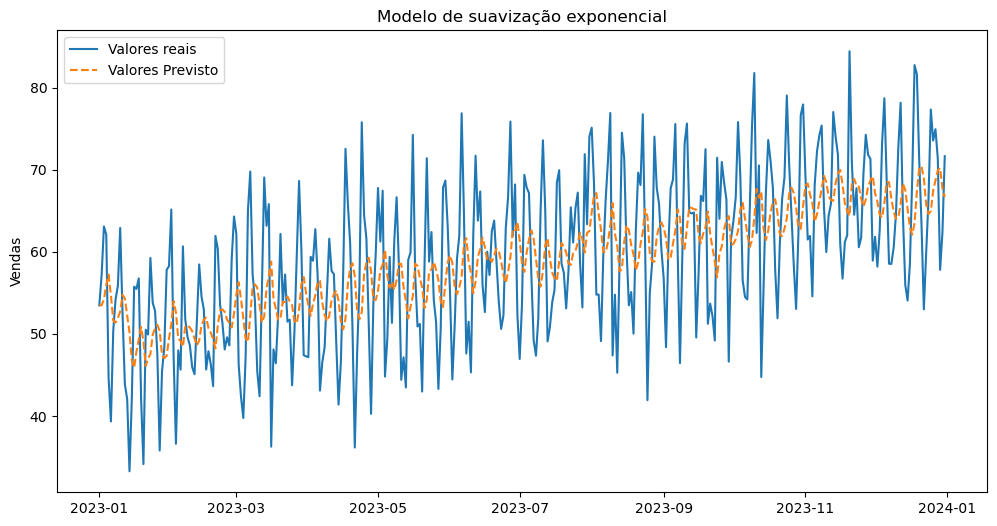

In [31]:
# plot
plt.figure(figsize=(12,6))
plt.plot(serie_temporal, label='Valores reais')
plt.plot(suavizacao_exponencial, label='Valores Previsto', linestyle='--')
plt.ylabel('Data') # Label
plt.ylabel('Vendas') # Label
plt.title('Modelo de suavização exponencial')
plt.legend()
plt.show()

#### Deploy e previsão com o modelo treinado

In [39]:
# fazer previsões
num_previsoes = 1
previsoes = modelo_ajustado.forecast(steps=num_previsoes)
print('Previsão do total de vendas para Janeiro/24:', round(previsoes[0],4))

Previsão do total de vendas para Janeiro/24: 67.6499



=== Previsões para os próximos 30 dias ===
             Previsão
Data                 
2024-01-01  67.649892
2024-01-02  67.649892
2024-01-03  67.649892
2024-01-04  67.649892
2024-01-05  67.649892
2024-01-06  67.649892
2024-01-07  67.649892
2024-01-08  67.649892
2024-01-09  67.649892
2024-01-10  67.649892
2024-01-11  67.649892
2024-01-12  67.649892
2024-01-13  67.649892
2024-01-14  67.649892
2024-01-15  67.649892
2024-01-16  67.649892
2024-01-17  67.649892
2024-01-18  67.649892
2024-01-19  67.649892
2024-01-20  67.649892
2024-01-21  67.649892
2024-01-22  67.649892
2024-01-23  67.649892
2024-01-24  67.649892
2024-01-25  67.649892
2024-01-26  67.649892
2024-01-27  67.649892
2024-01-28  67.649892
2024-01-29  67.649892
2024-01-30  67.649892


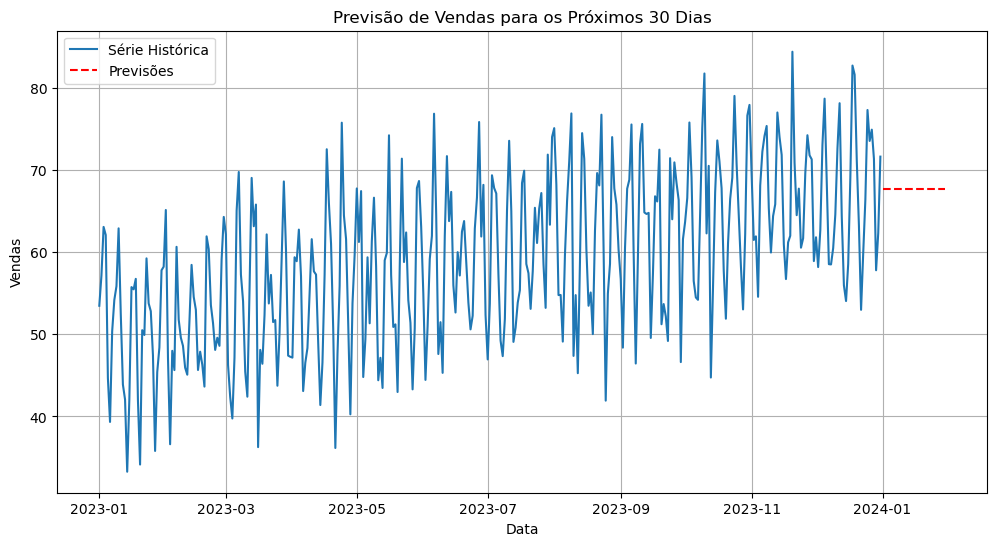

In [40]:

# Definir o número de previsões
num_previsoes = 30

# Fazer as previsões para os próximos 30 dias
previsoes = modelo_ajustado.forecast(steps=num_previsoes)

# Criar um índice de datas para os próximos 30 dias
inicio_previsao = serie_temporal.index[-1] + pd.Timedelta(days=1)
datas_previsao = pd.date_range(start=inicio_previsao, periods=num_previsoes, freq='D')

# Converter previsões para um DataFrame para facilitar
df_previsoes = pd.DataFrame({'Data': datas_previsao, 'Previsão': previsoes})
df_previsoes.set_index('Data', inplace=True)

# Exibir as previsões
print("\n=== Previsões para os próximos 30 dias ===")
print(df_previsoes)

# Plotar a série original + previsões
plt.figure(figsize=(12,6))
plt.plot(serie_temporal, label='Série Histórica')
plt.plot(df_previsoes, label='Previsões', linestyle='dashed', color='red')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Previsão de Vendas para os Próximos 30 Dias')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
print(modelo_ajustado.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:           Total_Vendas   No. Observations:                  365
Model:             SimpleExpSmoothing   SSE                          29957.174
Optimized:                      False   AIC                           1612.784
Trend:                           None   BIC                           1620.584
Seasonal:                        None   AICC                          1612.895
Seasonal Periods:                None   Date:                 Tue, 19 Aug 2025
Box-Cox:                        False   Time:                         23:10:23
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
initial_level              53.483571                